In [ ]:
library(dyngen)
# https://github.com/No2Ross/TrAGEDy/blob/main/TrAGEDy_paper_code/Dyngen_simulations/not_shared/not_shared_Dyngen_simulate.R
set.seed(2)
backbone <- backbone_linear()

config <-
  initialise_model(
    backbone = backbone,
    num_cells = 2000,
    num_tfs = nrow(backbone$module_info),
    num_targets = 300,
    num_hks = 300,
    simulation_params = simulation_default(
      census_interval = 10, 
      ssa_algorithm = ssa_etl(tau = 300 / 3600),
      experiment_params = simulation_type_wild_type(num_simulations = 300),
      total_time = 300
      
    )
  )

model_1_config <-
  config %>%
  generate_tf_network() %>%
  generate_feature_network() %>% 
  generate_kinetics() %>%
  generate_gold_standard()

model_2_config <-
  config %>%
  generate_tf_network() %>%
  generate_feature_network() %>% 
  generate_kinetics() %>%
  generate_gold_standard()


plot_backbone_modulenet(model_1_config)

plot_backbone_statenet(model_1_config)


plot_backbone_modulenet(model_2_config)

plot_backbone_statenet(model_2_config)

model_1 <- model_1_config %>%
  generate_cells()%>%
  generate_experiment()


model_2 <- model_2_config %>%
  generate_cells() %>%
  generate_experiment()

model_1_seurat <- as_seurat(model_1)
model_2_seurat <- as_seurat(model_2)

In [38]:
saveRDS(model_1_seurat, "DynGenSimulatedData/Robjects/negative_control_1.rds")
saveRDS(model_2_seurat, "DynGenSimulatedData/Robjects/negative_control_2.rds")

In [17]:
c_obj 

An object of class Seurat 
2476 features across 2000 samples within 4 assays 
Active assay: RNA (619 features, 619 variable features)
 3 other assays present: spliced, unspliced, protein
 3 dimensional reductions calculated: MDS, pca, umap

In [18]:
d_obj 

An object of class Seurat 
2476 features across 1940 samples within 4 assays 
Active assay: RNA (619 features, 619 variable features)
 3 other assays present: spliced, unspliced, protein
 3 dimensional reductions calculated: MDS, pca, umap

In [1]:
suppressMessages(library(tidyverse)) 
suppressMessages(library(Seurat))
suppressMessages(library(slingshot))
suppressMessages(library(SingleCellExperiment))
suppressMessages(library(cellAlign))

c_obj <- readRDS("DynGenSimulatedData/Robjects/negative_control_1.rds")
d_obj <- readRDS( "DynGenSimulatedData/Robjects/negative_control_2.rds")

output <- list(c_obj, d_obj)

for (i in 1:length(output)){
  current <- output[[i]]
  current <- NormalizeData(current)
  current <- FindVariableFeatures(current, selection.method = "vst", nfeatures = 2000)
  all.genes <- rownames(current)
  current <- ScaleData(current, features = all.genes)
  current <- RunPCA(current, features = VariableFeatures(object = current))
  #print(ElbowPlot(current, ndims = 50))
  current <- FindNeighbors(current, dims = 1:15)
  current <- FindClusters(current, resolution = 0.5)
  #print(DimPlot(current, reduction = "pca"))
  current <- RunUMAP(current, dims = 1:15, n.components = 2)
  output[[i]] <- current
}

c_obj <- output[[1]]
d_obj <- output[[2]]
#remove outlier in the d object 
## <--- [NOTE_G2G: this has been done in TrAGEDy script but not in cellalign script leading to NA values in d_pseudo. Therefore, we the G2G team run this for correctness and consistency]
d_obj <- subset(d_obj, seurat_clusters != "7")

c.markers <- FindAllMarkers(c_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
c.markers_top15 <- c.markers %>%
  group_by(cluster) %>%
  slice_max(n = 100, order_by = avg_log2FC)
d.markers <- FindAllMarkers(d_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
d.markers_top15 <- d.markers %>%
  group_by(cluster) %>%
  slice_max(n = 100, order_by = avg_log2FC)
features <- unique(d.markers_top15$gene, c.markers_top15$gene)
c_obj@assays$RNA@var.features <- features
d_obj@assays$RNA@var.features <- features
features <- c_obj@assays$RNA@var.features

#2: create trajectories seperately
c_sce <- as.SingleCellExperiment(c_obj, assay = "RNA")
start_cluster_1 <- levels(c_obj$seurat_clusters)[which(table(c_obj$seurat_clusters[which(c_obj$sim_time == 0)]) == max(table(c_obj$seurat_clusters[which(c_obj$sim_time == 0)])))]
c_sce <- slingshot(c_sce, reducedDim = 'UMAP', clusterLabels = c_sce@colData@listData[["RNA_snn_res.0.5"]], start.clus = start_cluster_1)
c_sling <- SlingshotDataSet(c_sce)
d_sce <- as.SingleCellExperiment(d_obj, assay = "RNA")
start_cluster_2 <- levels(d_obj$seurat_clusters)[which(table(d_obj$seurat_clusters[which(d_obj$sim_time == 0)]) == max(table(d_obj$seurat_clusters[which(d_obj$sim_time == 0)])))]
d_sce <- slingshot(d_sce, reducedDim = 'UMAP', clusterLabels = d_sce@colData@listData[["RNA_snn_res.0.5"]], start.clus = start_cluster_2)
d_sling <- SlingshotDataSet(d_sce)
pseudo_end <- min(c(max(d_sce$slingPseudotime_1, c_sce$slingPseudotime_1, na.rm = T)))
window <- pseudo_end / 45;


Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
Centering and scaling data matrix

PC_ 1 
Positive:  Target101, Target120, Target6, Target284, Target250, Target252, Target245, Target243, Target81, Target236 
	   Target3, Target300, Target34, Target255, Target159, Target257, Target251, Target145, Target8, Target71 
	   Target104, Target176, Target237, Target92, Target139, Target256, Target248, Targ

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2000
Number of edges: 85514

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8626
Number of communities: 6
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:04:36 UMAP embedding parameters a = 0.9922 b = 1.112

16:04:36 Read 2000 rows and found 15 numeric columns

16:04:36 Using Annoy for neighbor search, n_neighbors = 30

16:04:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:04:37 Writing NN index file to temp file /tmp/RtmpeHd63G/file3b629b2b5d7

16:04:37 Searching Annoy index using 1 thread, search_k = 3000

16:04:37 Annoy recall = 100%

16:04:38 Commencing smooth kNN distance calibration using 1 thread

16:04:39 Initializing from

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2000
Number of edges: 90308

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8654
Number of communities: 8
Elapsed time: 0 seconds


16:04:46 UMAP embedding parameters a = 0.9922 b = 1.112

16:04:46 Read 2000 rows and found 15 numeric columns

16:04:46 Using Annoy for neighbor search, n_neighbors = 30

16:04:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:04:47 Writing NN index file to temp file /tmp/RtmpeHd63G/file3b621c7d760d

16:04:47 Searching Annoy index using 1 thread, search_k = 3000

16:04:47 Annoy recall = 100%

16:04:48 Commencing smooth kNN distance calibration using 1 thread

16:04:49 Initializing from normalized Laplacian + noise

16:04:49 Commencing optimization for 500 epochs, with 84866 positive edges

16:04:52 Optimization finished

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculat

In [2]:
c_obj

An object of class Seurat 
2476 features across 2000 samples within 4 assays 
Active assay: RNA (619 features, 507 variable features)
 3 other assays present: spliced, unspliced, protein
 3 dimensional reductions calculated: MDS, pca, umap

In [3]:
d_obj

An object of class Seurat 
2476 features across 1940 samples within 4 assays 
Active assay: RNA (619 features, 507 variable features)
 3 other assays present: spliced, unspliced, protein
 3 dimensional reductions calculated: MDS, pca, umap

In [4]:
library(pheatmap)

run_cellAlign_genelevel <- function(c_data, d_data, GENE, filename='Z.png'){

    numPts = 50
    interGlobalc = cellAlign::interWeights(expDataBatch = c_data, trajCond = c_pseudo,
                                           winSz = window, numPts = numPts)
    interGlobald = cellAlign::interWeights(expDataBatch = d_data, trajCond = d_pseudo,
                                           winSz = window, numPts = numPts)

    interScaledGlobalc = cellAlign::scaleInterpolate(interGlobalc)
    interScaledGlobald = cellAlign::scaleInterpolate(interGlobald)

    alignment = globalAlign(as.data.frame(interScaledGlobalc$scaledData)[GENE,], as.data.frame(interScaledGlobald$scaledData)[GENE,],
                            scores = list(query = interScaledGlobalc$traj, 
                                          ref = interScaledGlobald$traj),
                            sigCalc = F, numPerm = 20, dist.method = "Euclidean", normDist = F)
    plotAlign2(alignment, filename=filename)
}

# function from CellAlign, edited to output a black color alignment path in the plot
plotAlign2 <- function(alignment, filename='Z.png'){

  costMat = alignment$localCostMatrix

  costMat = t(apply(costMat,1,function(x){return(as.numeric(x))}))
  linearInd = sub2ind(nrow(costMat), alignment$align[[1]]$index1, alignment$align[[1]]$index2)
  costMat[linearInd] = NA
  costMat = data.frame(costMat, row.names=1:nrow(costMat))
  colnames(costMat) = 1:ncol(costMat)
  #for global alignment, where there is a pseudotime shift vector:
  if(!is.null(alignment$ptShift)){
    annotCols = data.frame(ptShift = abs(alignment$ptShift), sign = factor(sign(alignment$ptShift)),row.names = colnames(costMat))

    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA,
             main = 'alignment plot',
             show_rownames = T, show_colnames = T, annotation_col = annotCols,na_col = "black", filename= filename)

  }else{
    phm = pheatmap(costMat, cluster_cols = F, cluster_rows=F, border_color = NA,
             main = 'alignment plot', show_rownames = T, show_colnames = T,na_col = "black", filename= filename)
  }
  return(NA)
}



In [5]:

run_cellAlign<- function(c_data, d_data, filename){
    numPts = 50
    interGlobalc = cellAlign::interWeights(expDataBatch = c_data, trajCond = c_pseudo,
                                           winSz = window, numPts = numPts)
    interGlobald = cellAlign::interWeights(expDataBatch = d_data, trajCond = d_pseudo,
                                           winSz = window, numPts = numPts)

    interScaledGlobalc = cellAlign::scaleInterpolate(interGlobalc)
    interScaledGlobald = cellAlign::scaleInterpolate(interGlobald)

  #  interScaledGlobalc$scaledData <- interScaledGlobalc$scaledData[ which( row.names(interScaledGlobalc$scaledData) %in% features), ]
  #  interScaledGlobald$scaledData <- interScaledGlobald$scaledData[ which( row.names(interScaledGlobald$scaledData) %in% features), ]
  #  interScaledGlobalc$scaledError <- interScaledGlobalc$scaledError[ which( row.names(interScaledGlobalc$scaledError) %in% features), ]
  #  interScaledGlobald$scaledError <- interScaledGlobald$scaledError[ which( row.names(interScaledGlobald$scaledError) %in% features), ]
    
    print(dim(interScaledGlobalc$scaledData))
    print('----')
    print(dim(interScaledGlobald$scaledData))

    alignment = globalAlign(interScaledGlobalc$scaledData, interScaledGlobald$scaledData,
                            scores = list(query = interScaledGlobalc$traj, 
                                          ref = interScaledGlobald$traj),
                            sigCalc = F, numPerm = 20, dist.method = "Euclidean", normDist = F)
    
    plotAlign2(alignment, filename= filename)
    
   # return(rownames(interScaledGlobalc$scaledData))
}
# Input the scaled log normalised data insetad since CellAlign input is log normalised expression
c_data <- as.matrix(c_sce@assays@data$scaledata)
d_data <- as.matrix(d_sce@assays@data$scaledata)
c_pseudo <- as.numeric(c_sce$slingPseudotime_1)
d_pseudo <- as.numeric(d_sce$slingPseudotime_1)

cellalign_used_features = run_cellAlign(c_data,d_data, filename = 'Plots/cellalign_plot_all_features.png')

[1] 619  50
[1] "----"
[1] 619  50


calculate dissimilarity matrix

calculate cost and step matrices

backtracking



In [6]:
#print(length(cellalign_used_features)) 
#write.csv(cellalign_used_features,'features_negcontrol_cellalign.csv') 

In [7]:
# reference c data in rows, query d data in columns
#'HK118','HK110','HK45']
run_cellAlign_genelevel(c_data,d_data, 'HK118', filename = 'Plots/CellAlign_HK118.png')
run_cellAlign_genelevel(c_data,d_data, 'HK110', filename = 'Plots/CellAlign_HK110.png')
run_cellAlign_genelevel(c_data,d_data, 'HK45', filename = 'Plots/CellAlign_HK45.png')

calculate dissimilarity matrix

calculate cost and step matrices

backtracking



[1] NA

calculate dissimilarity matrix

calculate cost and step matrices

backtracking



[1] NA

calculate dissimilarity matrix

calculate cost and step matrices

backtracking



[1] NA

### TrAGEDy Run

In [8]:
#Trade seq and STACAS do not get along 
library(reticulate)
#use_python("/usr/local/bin/python3.8")
#reticulate::import("phate")
library(gridExtra)
library(grid)
library(ggplot2)
library(lattice)
library(phateR)
library(dplyr)
library(Seurat)
library(rgl)
library(ggplot2)
library(ggpubr)
library(cowplot)
library(dtw)
library(scater)
library(scran)
library(clustree)
library(RColorBrewer)
library(SingleCellExperiment)
#library(clustree)
library(STACAS)
library(monocle)
library(slingshot)
library(stats)
library(stringi)
library(reshape2)
library(stringr)
library(mclust)
library(coin)
library(biomaRt)
library(metap)

#source("TrAGEDy_results/TrAGEDy_functions.R")
source("TrAGEDy/TrAGEDy_functions.R")


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


This build of rgl does not include OpenGL functions.  Use
 rglwidget() to display results, e.g. via options(rgl.printRglwidget = TRUE).

Warning message:
“package ‘ggpubr’ was built under R version 4.1.3”
Warning message:
“package ‘cowplot’ was built under R version 4.1.3”

Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Loading required package: proxy

Warning message:
“package ‘proxy’ was built under R version 4.1.3”

Attaching package: ‘proxy’


The following object is ma

Centering and scaling data matrix

PC_ 1 
Positive:  Target101, Target120, Target6, Target284, Target250, Target252, Target245, Target243, Target81, Target236 
	   Target3, Target300, Target34, Target255, Target159, Target257, Target251, Target145, Target8, Target71 
	   Target104, Target176, Target237, Target92, Target139, Target256, Target248, Target53, Target253, Target234 
Negative:  Target30, Target25, Target33, Target64, Target85, Target286, Target112, Target105, Target32, Target289 
	   Target67, Target29, Target28, Target1, Target281, Target77, Target87, Target299, Target298, Target277 
	   Target86, Target31, Target88, Target24, Target292, Target83, Target293, Target82, Target121, Target35 
PC_ 2 
Positive:  Target205, Target53, Target42, Target209, Target158, Target105, Target102, Target152, Target208, Target103 
	   Target81, A6-TF1, Target297, Target117, Target40, Target165, Target129, Target100, Target114, Target296 
	   Target137, Target95, Target148, Target122, Target270

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2000
Number of edges: 85514

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8626
Number of communities: 6
Elapsed time: 0 seconds


16:06:13 UMAP embedding parameters a = 0.9922 b = 1.112

16:06:13 Read 2000 rows and found 15 numeric columns

16:06:13 Using Annoy for neighbor search, n_neighbors = 30

16:06:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:06:13 Writing NN index file to temp file /tmp/RtmpeHd63G/file3b626f60f8ae

16:06:13 Searching Annoy index using 1 thread, search_k = 3000

16:06:13 Annoy recall = 100%

16:06:14 Commencing smooth kNN distance calibration using 1 thread

16:06:16 Initializing from normalized Laplacian + noise

16:06:16 Commencing optimization for 500 epochs, with 82826 positive edges

16:06:19 Optimization finished

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 9 features r

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2000
Number of edges: 90308

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8654
Number of communities: 8
Elapsed time: 0 seconds


16:06:23 UMAP embedding parameters a = 0.9922 b = 1.112

16:06:23 Read 2000 rows and found 15 numeric columns

16:06:23 Using Annoy for neighbor search, n_neighbors = 30

16:06:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:06:24 Writing NN index file to temp file /tmp/RtmpeHd63G/file3b6299690e9

16:06:24 Searching Annoy index using 1 thread, search_k = 3000

16:06:24 Annoy recall = 100%

16:06:25 Commencing smooth kNN distance calibration using 1 thread

16:06:27 Initializing from normalized Laplacian + noise

16:06:27 Commencing optimization for 500 epochs, with 84866 positive edges

16:06:31 Optimization finished

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculati

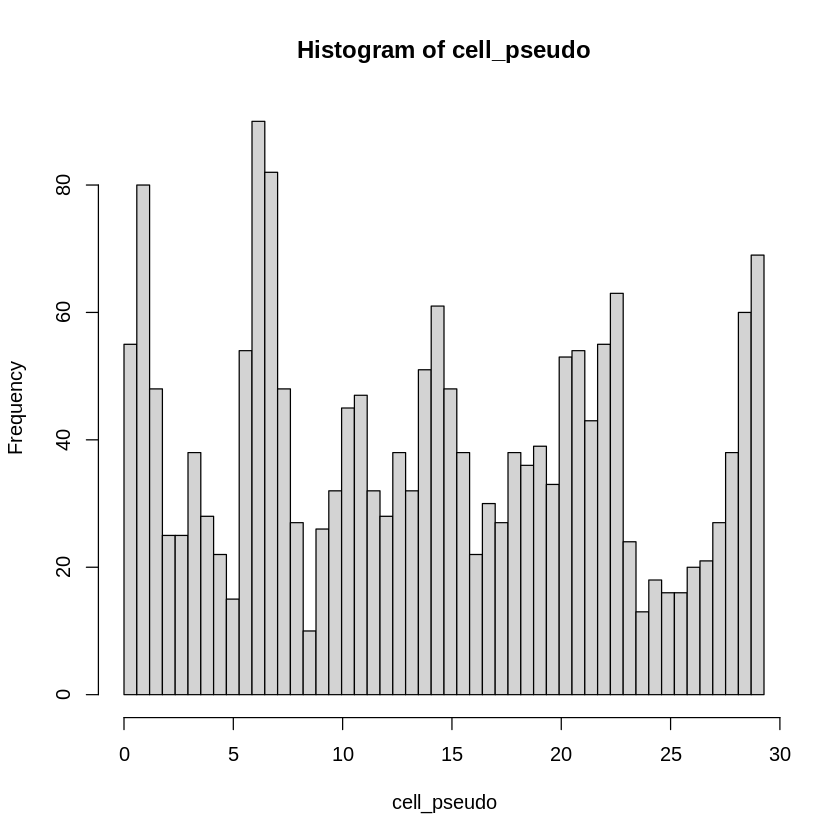

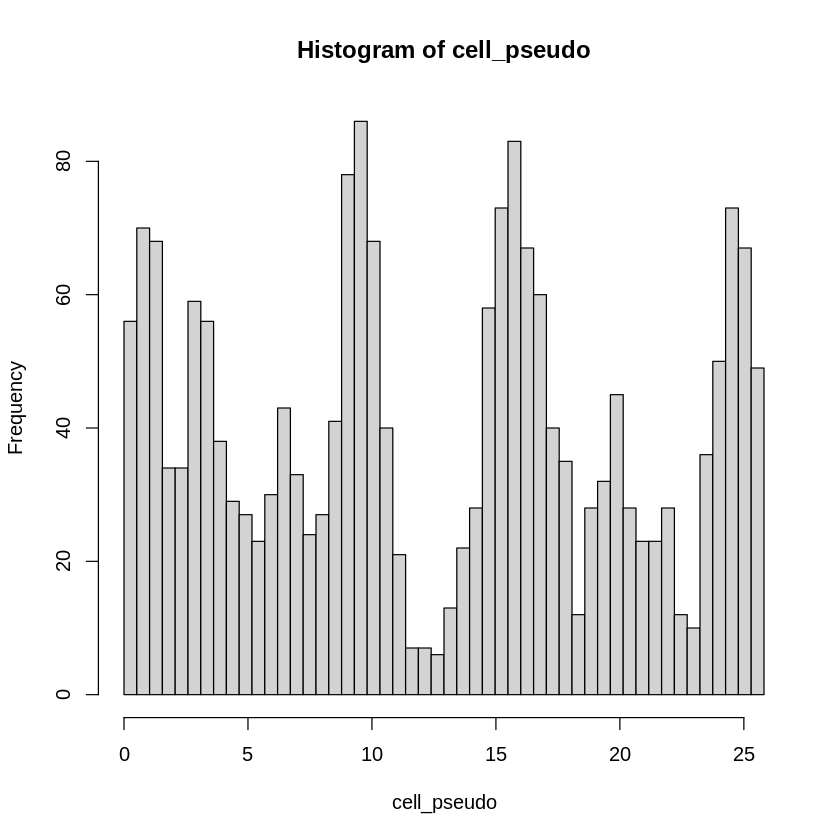

In [9]:
c_obj <- readRDS("DynGenSimulatedData/Robjects/negative_control_1.rds")
d_obj <- readRDS("DynGenSimulatedData/Robjects/negative_control_2.rds")

output <- list(c_obj, d_obj)

for (i in 1:length(output)){
  current <- output[[i]]
  current <- NormalizeData(current)
  current@assays$RNA@var.features <- row.names(current)
  all.genes <- rownames(current)
  current <- ScaleData(current, features = all.genes)
  current <- RunPCA(current, features = VariableFeatures(object = current))
  #print(ElbowPlot(current, ndims = 50))
  current <- FindNeighbors(current, dims = 1:15)
  current <- FindClusters(current, resolution = 0.5)
  current <- RunUMAP(current, dims = 1:15, n.components = 2)
  #print(DimPlot(current, reduction = "umap"))
  output[[i]] <- current
  
}

c_obj <- output[[1]]
d_obj <- output[[2]]

#remove outlier in the d object
d_obj <- subset(d_obj, seurat_clusters != "7")
c_sce <- as.SingleCellExperiment(c_obj, assay = "RNA")
start_cluster_1 <- levels(c_obj$seurat_clusters)[which(table(c_obj$seurat_clusters[which(c_obj$sim_time == 0)]) == max(table(c_obj$seurat_clusters[which(c_obj$sim_time == 0)])))]
c_sce <- slingshot(c_sce, reducedDim = 'UMAP', clusterLabels = c_sce@colData@listData[["RNA_snn_res.0.5"]], start.clus = start_cluster_1)
d_sce <- as.SingleCellExperiment(d_obj, assay = "RNA")
start_cluster_2 <- levels(d_obj$seurat_clusters)[which(table(d_obj$seurat_clusters[which(d_obj$sim_time == 0)]) == max(table(d_obj$seurat_clusters[which(d_obj$sim_time == 0)])))]
d_sce <- slingshot(d_sce, reducedDim = 'UMAP', clusterLabels = d_sce@colData@listData[["RNA_snn_res.0.5"]], start.clus = start_cluster_2)
d_sling <- SlingshotDataSet(d_sce)

WT.markers <- FindAllMarkers(c_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
WT.markers_top15 <- WT.markers %>%
  group_by(cluster) %>%
  slice_max(n = 100, order_by = avg_log2FC)
KO.markers <- FindAllMarkers(d_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
KO.markers_top15 <- KO.markers %>%
  group_by(cluster) %>%
  slice_max(n = 100, order_by = avg_log2FC)

features <- unique(c(KO.markers_top15$gene, WT.markers_top15$gene))
pseudo_end <- min(c(max(d_sce$slingPseudotime_1, c_sce$slingPseudotime_1, na.rm = T)))
window <- pseudo_end / 45

#3: create metacells across pseudotime 
c_cell_pseudotime <- matrix(c_sce$slingPseudotime_1, dimnames =list(c_sce@colData@rownames))
d_cell_pseudotime <- matrix(d_sce$slingPseudotime_1, dimnames =list(d_sce@colData@rownames))
c_ID <- data.frame(c_sce$seurat_clusters, row.names =c_sce@colData@rownames)
d_ID <- data.frame(d_sce$seurat_clusters, row.names =d_sce@colData@rownames)

c_tree <- nodePseudotime(c_cell_pseudotime,c_ID, 50, "WT")
d_tree <- nodePseudotime(d_cell_pseudotime,d_ID, 50, "KO")

#cellalign node exp mtx - not scaled with cellalign way
d_cell_pseudo <- data.frame("ID" = d_sce@colData@rownames, "pseudo" = d_sce$slingPseudotime_1)
d_node_pseudo <- data.frame("ID" = row.names(d_tree$pseudotime), "pseudo" = d_tree$pseudotime$pseudotime)

c_cell_pseudo <- data.frame("ID" = c_sce@colData@rownames, "pseudo" = c_sce$slingPseudotime_1)
c_node_pseudo <- data.frame("ID" = row.names(c_tree$pseudotime), "pseudo" = c_tree$pseudotime$pseudotime)

d_node_pseudotime <- matrix(d_tree$pseudotime$pseudotime , dimnames = list(row.names(d_tree$pseudotime)), )
c_node_pseudotime <- matrix(c_tree$pseudotime$pseudotime , dimnames = list(row.names(c_tree$pseudotime)), )

d_node_exp_mtx <- nodeExpressionEstimate(d_sce@assays@data@listData$logcounts, d_node_pseudotime, d_cell_pseudotime, window, adjust.window = T)
c_node_exp_mtx <- nodeExpressionEstimate(c_sce@assays@data@listData$logcounts, c_node_pseudotime, c_cell_pseudotime, window, adjust.window = T)

In [10]:
d_obj

An object of class Seurat 
2476 features across 1940 samples within 4 assays 
Active assay: RNA (619 features, 619 variable features)
 3 other assays present: spliced, unspliced, protein
 3 dimensional reductions calculated: MDS, pca, umap

In [11]:
c_obj

An object of class Seurat 
2476 features across 2000 samples within 4 assays 
Active assay: RNA (619 features, 619 variable features)
 3 other assays present: spliced, unspliced, protein
 3 dimensional reductions calculated: MDS, pca, umap

[1] 619  50
[1] 619  50


Warning message in if (index_choice == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "The mean score of your optimal path is 1.02420017738271. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


[1] 310


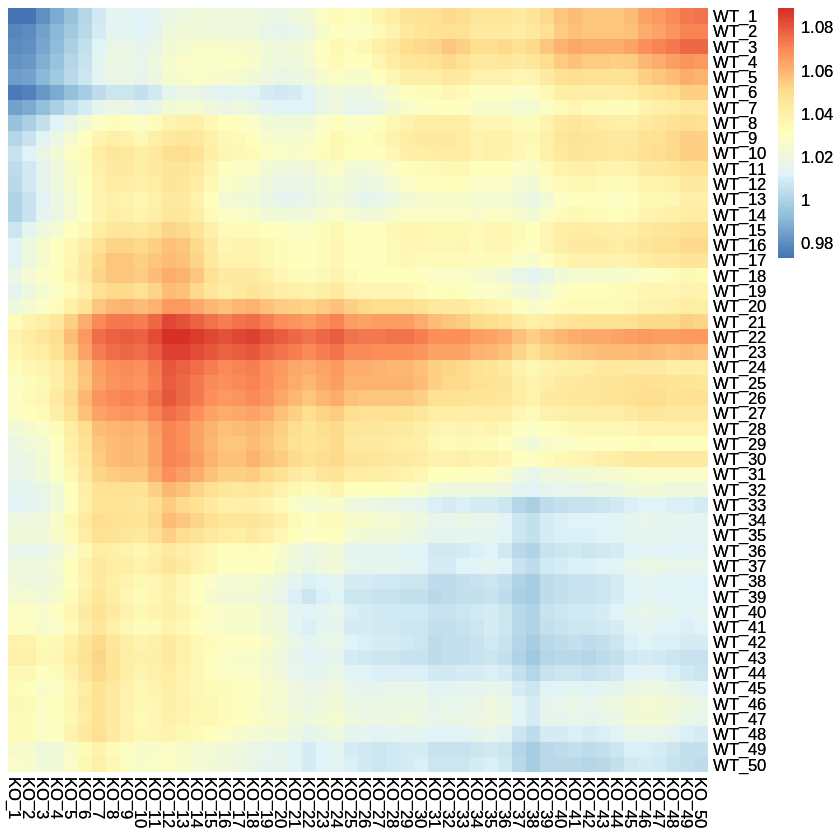

In [13]:
run_TrAGEDY <- function(c_node_exp_mtx, d_node_exp_mtx, filename='Z.png'){
  #  d_node_exp_mtx  <- d_node_exp_mtx[ features, ]
  #  c_node_exp_mtx <- c_node_exp_mtx[ features, ]

    print(dim(c_node_exp_mtx))
    print(dim(d_node_exp_mtx))
    #3.5: remove genes from our feature space which are not temporarily regulated in our process

    #4.1: Create correlation matrix based on the new feature space we used across the metacells
    row.names(as.matrix(d_node_exp_mtx)) == row.names(as.matrix(c_node_exp_mtx))

    penalty_mtx_cut <- dis_mtx_calculator(as.matrix(c_node_exp_mtx), as.matrix(d_node_exp_mtx), "spearman")

    output_solution <- pathfind(penalty_mtx_cut, cut_type = "minimum", method = "mean")
    output_solution_cut <- cut_deviate(output_solution, penalty_mtx_cut, method = "mean")

    #output_solution_cut$Status <- rep("cut", length(output_solution_cut$Status))
    PlotAlignment2(output_solution_cut, penalty_mtx_cut, filename=filename)
}

# Function from TrAGEDy script, edited to output a black color alignment path
PlotAlignment2 <- function(alignment, score_mtx, filename){
  cut_alignment <- alignment[alignment$Status == "match",]
  score_mtx <- t(score_mtx)
  score_mtx[as.matrix(cut_alignment[,1:2])] <- NA
  myColor <- colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(200)
  breaks_plot <- seq(0, max(score_mtx, na.rm=T), (max(score_mtx, na.rm=T)/200))
  return(pheatmap::pheatmap(as.matrix(score_mtx), cluster_rows = F, cluster_cols = F, scale="none", border_color = NA, margins = c(8,8),  breaks = breaks_plot, color = myColor, cexCol = 0.2,na_col = "Black", filename=filename))
}

run_TrAGEDY(c_node_exp_mtx, d_node_exp_mtx, filename='Plots/TrAGEDy_plot_all_features.png')

print(length(features)) 
write.csv(features,'features_negcontrol_TrAGEDy.csv') 

In [15]:
run_TrAGEDY_genelevel <- function(c_node_exp_mtx, d_node_exp_mtx, GENE, method, filename='Z.png'){
    M = as(matrix(c_node_exp_mtx[unique(c(GENE)), ], nrow=1), 'dgeMatrix')
    rownames(M) = c(GENE)
    colnames(M) = colnames(c_node_exp_mtx)
    M1 <-M
    print(dim(M1))
    M = as(matrix(d_node_exp_mtx[unique(c(GENE)), ], nrow=1), 'dgeMatrix')
    rownames(M) = c(GENE)    
    colnames(M) = colnames(d_node_exp_mtx)
    M2 <-M
    print(dim(M2))
    #4.1: Create correlation matrix based on the new feature space we used across the metacells
    row.names(as.matrix(M2)) == row.names(as.matrix(M1))

    #penalty_mtx_cut <- dis_mtx_calculator(as.matrix(M1), as.matrix(M2), "spearman")
    penalty_mtx_cut <- dis_mtx_calculator(as.matrix(M1), as.matrix(M2), "euclidean")

    output_solution <- pathfind(penalty_mtx_cut, cut_type = "minimum", method = method)
    output_solution_cut <- cut_deviate(output_solution, penalty_mtx_cut, method = method)

    #output_solution_cut$Status <- rep("cut", length(output_solution_cut$Status))
    PlotAlignment2(output_solution_cut, penalty_mtx_cut, filename=filename)
}


[1]  1 50
[1]  1 50


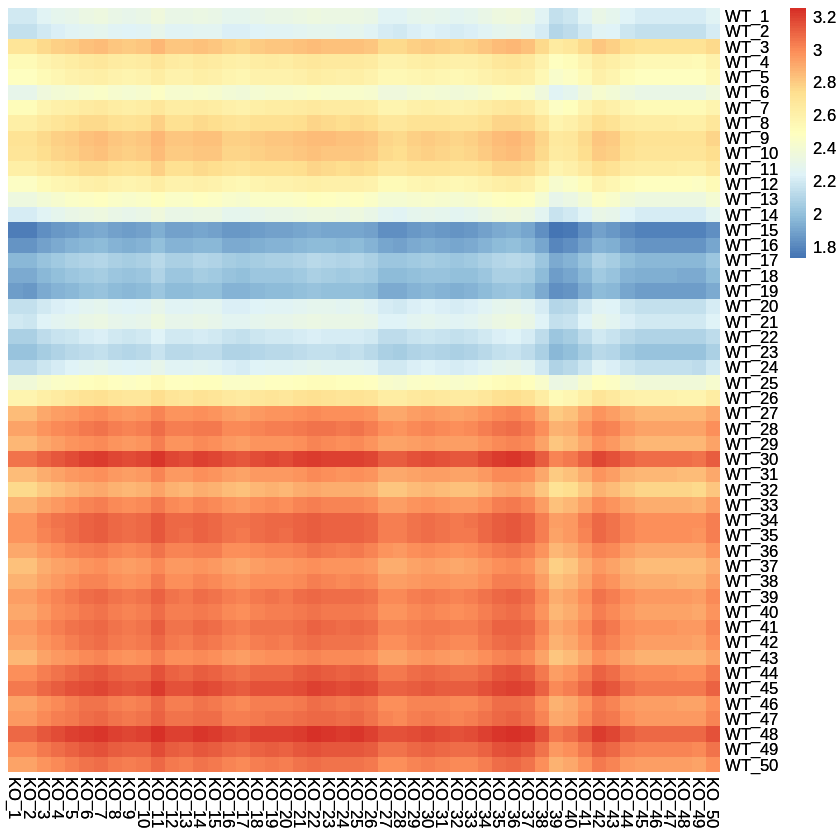

[1] "The mean score of your optimal path is 1.86988795894027. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


[1]  1 50
[1]  1 50
[1] "The mean score of your optimal path is 3.7558115797474. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


[1]  1 50
[1]  1 50
[1] "The mean score of your optimal path is 1.20939028608187. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


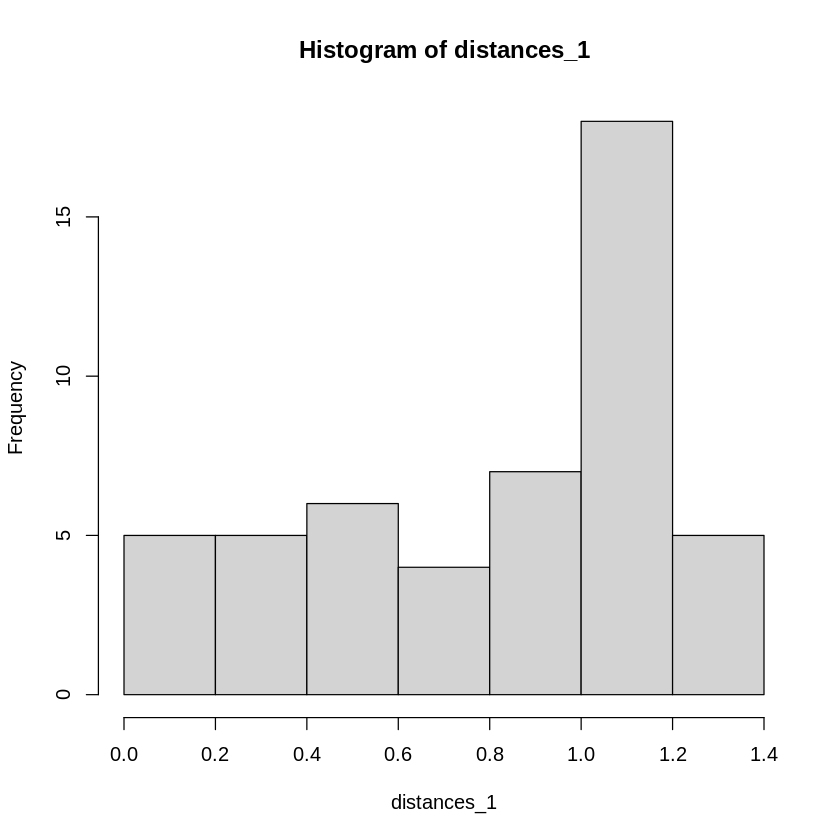

In [16]:
run_TrAGEDY_genelevel(c_node_exp_mtx, d_node_exp_mtx, 'HK118', 'mean', filename='Plots/TrAGEDy_HK118.png')
run_TrAGEDY_genelevel(c_node_exp_mtx, d_node_exp_mtx, 'HK110', 'mean', filename='Plots/TrAGEDy_HK110.png')
run_TrAGEDY_genelevel(c_node_exp_mtx, d_node_exp_mtx, 'HK45', 'mean', filename='Plots/TrAGEDy_HK45.png')

[1]  1 50
[1]  1 50


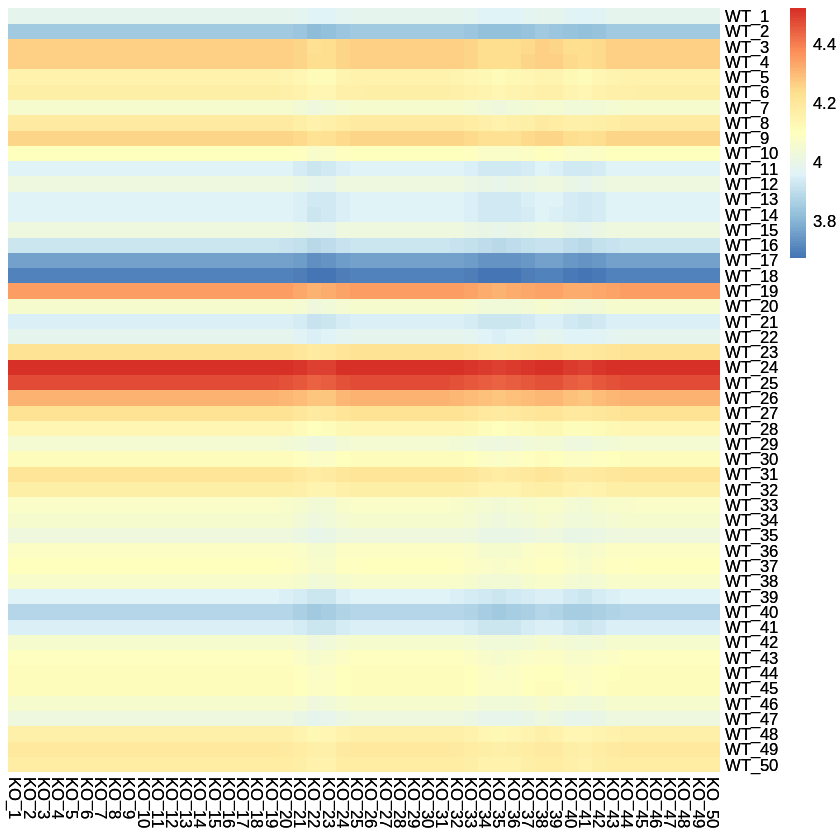

[1] "The mean score of your optimal path is 3.7558115797474. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


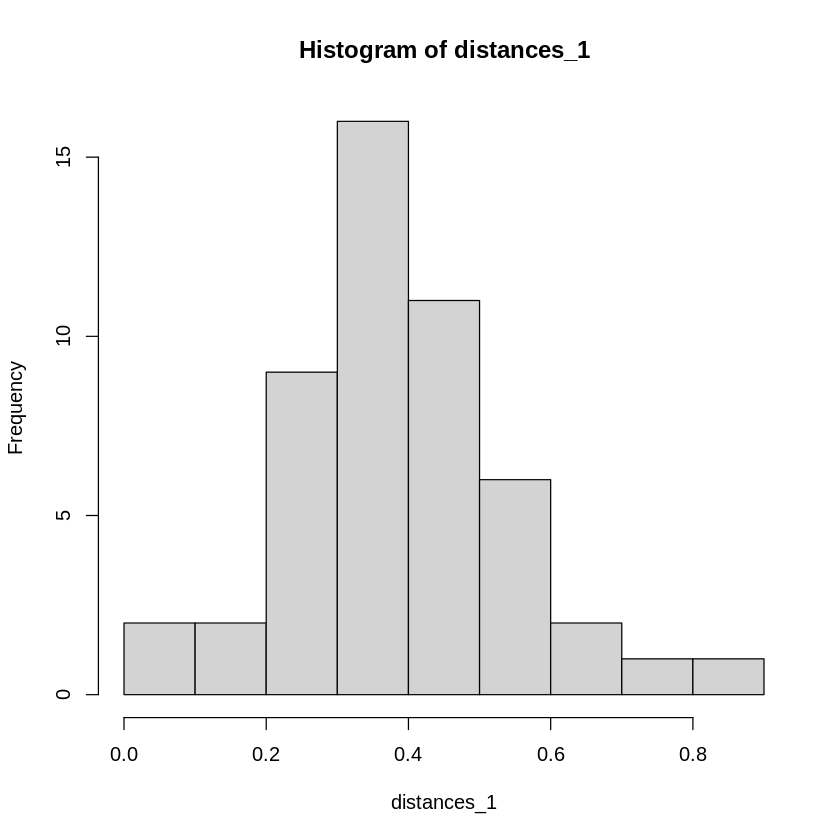

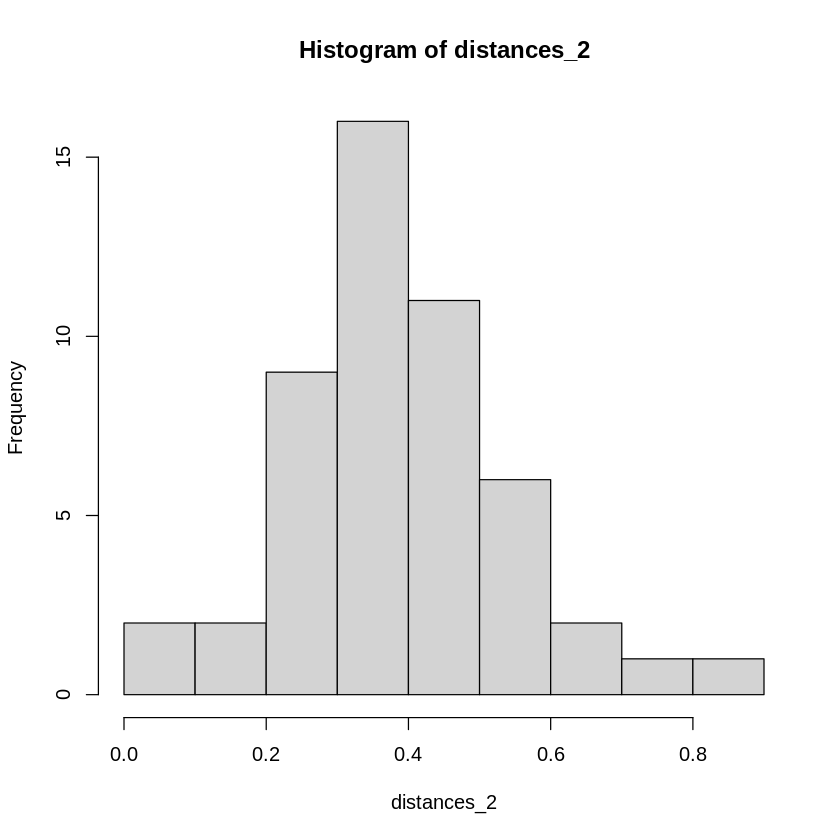

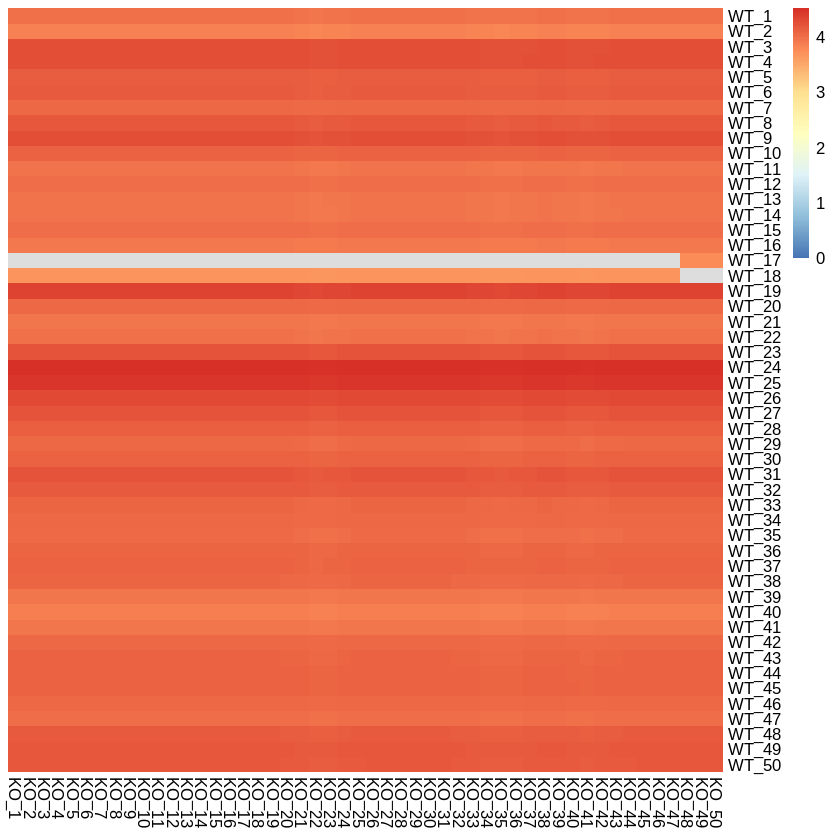

In [94]:
run_TrAGEDY_genelevel(c_node_exp_mtx, d_node_exp_mtx, 'HK110', 'mean')

[1]  1 50
[1]  1 50


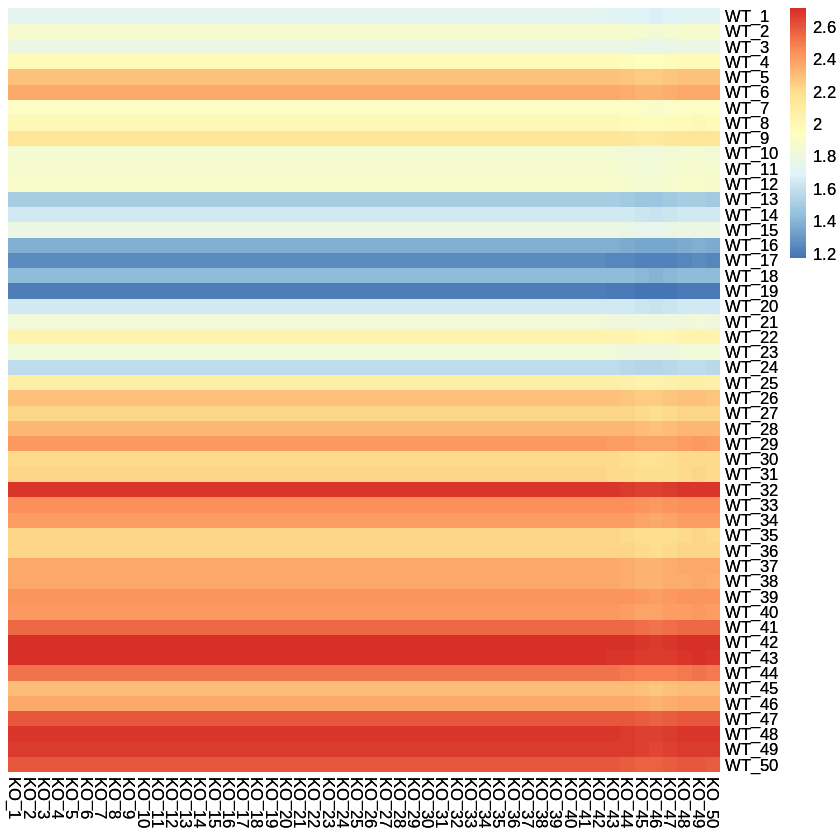

[1] "The mean score of your optimal path is 1.20939028608187. You should consider whether or not these two processes share a common process"


Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”
Warning message in get_thresholds(alignment, dis_mtx, method):
“NAs introduced by coercion”


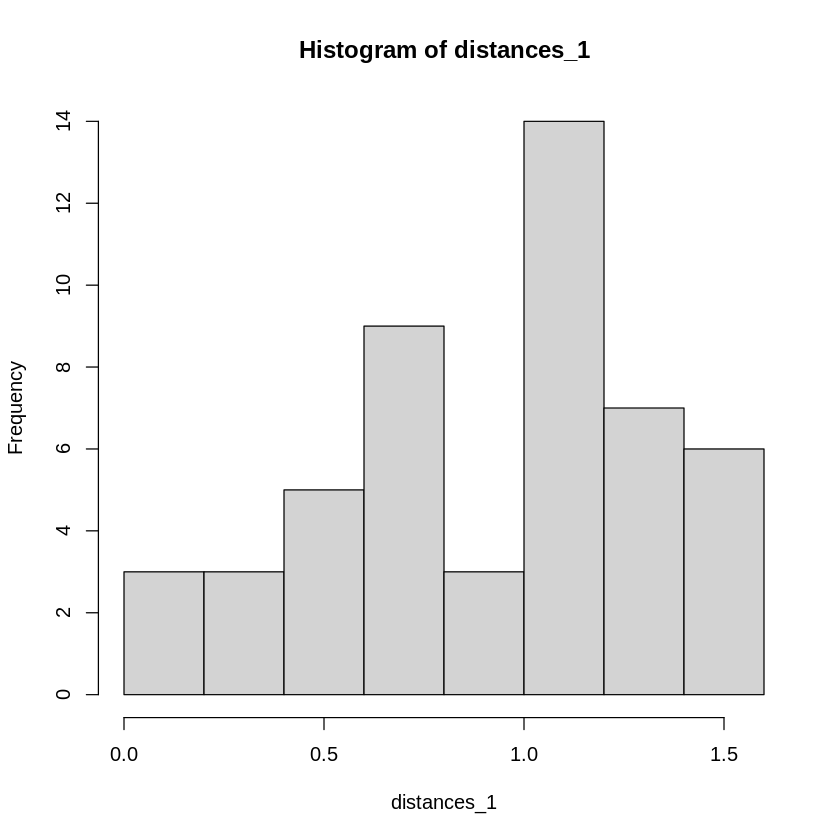

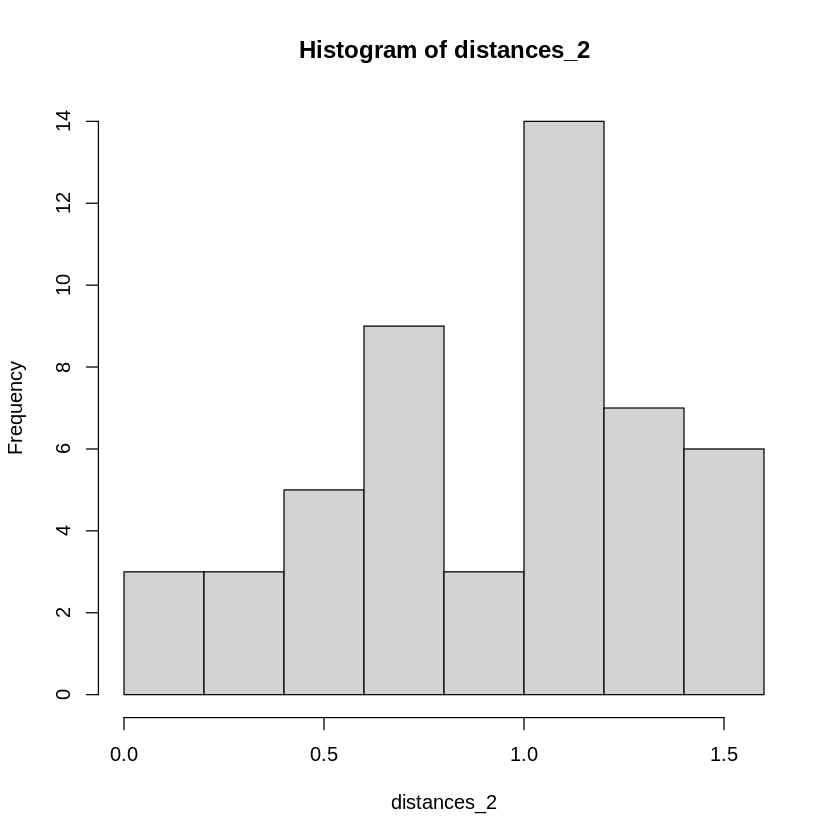

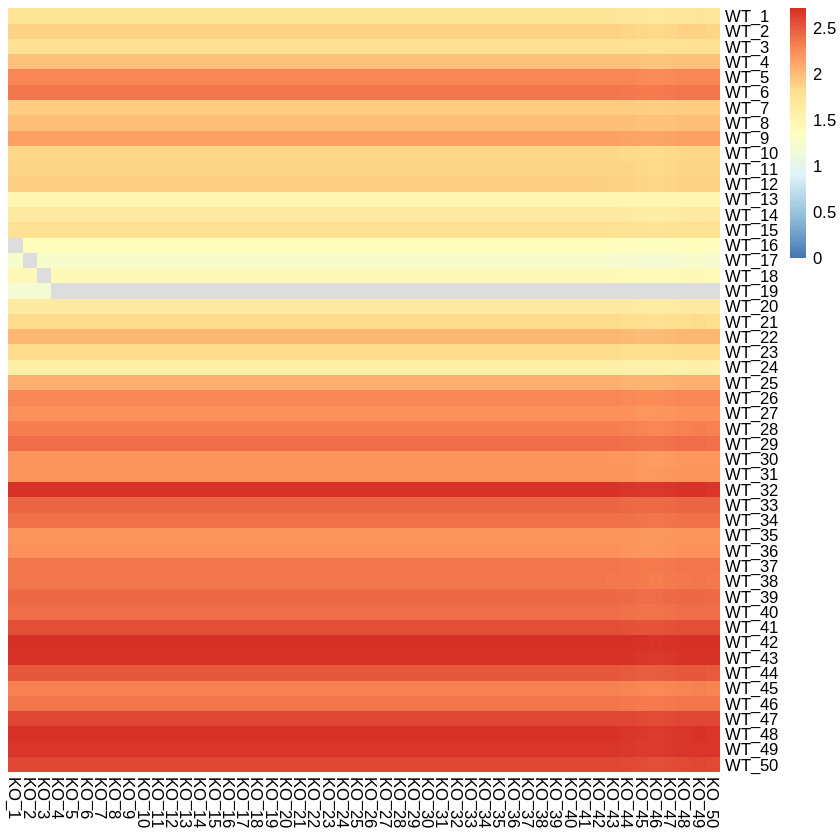

In [95]:
run_TrAGEDY_genelevel(c_node_exp_mtx, d_node_exp_mtx, 'HK45', 'mean')

In [15]:
# converting seurat objects to anndata objects for g2g alignment
library(sceasy)
c_pseudo <- as.numeric(c_sce$slingPseudotime_1)
d_pseudo <- as.numeric(d_sce$slingPseudotime_1)
c_obj$time = c_pseudo
d_obj$time = d_pseudo
sceasy::convertFormat(c_obj, from="seurat", to="anndata",
                       outFile='DynGenSimulatedData/AnndataObjects/adata_negative_control_1.h5ad')
sceasy::convertFormat(d_obj, from="seurat", to="anndata",
                       outFile='DynGenSimulatedData/AnndataObjects/adata_negative_control_2.h5ad')

Warning message in .regularise_df(obj@meta.data, drop_single_values = drop_single_values):
“Dropping single category variables:orig.ident”
Warning message in .regularise_df(Seurat::GetAssay(obj, assay = assay)@meta.features, :
“Dropping single category variables:independence, splicing_rate”


AnnData object with n_obs × n_vars = 2000 × 619
    obs: 'nCount_RNA', 'nFeature_RNA', 'step_ix', 'simulation_i', 'sim_time', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_protein', 'nFeature_protein', 'RNA_snn_res.0.5', 'seurat_clusters', 'time'
    var: 'module_id', 'basal', 'burn', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    obsm: 'X_mds', 'X_pca', 'X_umap'

Warning message in .regularise_df(obj@meta.data, drop_single_values = drop_single_values):
“Dropping single category variables:orig.ident”
Warning message in .regularise_df(Seurat::GetAssay(obj, assay = assay)@meta.features, :
“Dropping single category variables:independence, splicing_rate”


AnnData object with n_obs × n_vars = 1940 × 619
    obs: 'nCount_RNA', 'nFeature_RNA', 'step_ix', 'simulation_i', 'sim_time', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_protein', 'nFeature_protein', 'RNA_snn_res.0.5', 'seurat_clusters', 'time'
    var: 'module_id', 'basal', 'burn', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    obsm: 'X_mds', 'X_pca', 'X_umap'